In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import re
from wordcloud import WordCloud

In [2]:
outflows = pd.read_parquet('C:/Users/bdion/Downloads/DSC180A/dsc180a/DSC180A/data/ucsd-outflows.pqt')
outflows.posted_date = pd.to_datetime(outflows.posted_date, format='%Y-%m-%d')

In [3]:
outflows.memo

0                                               LOAN
1                                           ATM_CASH
2          TST* Casa Del Rio - Exp Fairlawn OH 09/24
3                                               LOAN
4                                 Buffalo Wild Wings
                             ...                    
2597483                                     ATM_CASH
2597484                                     ATM_CASH
2597485                                     ATM_CASH
2597486                                     ATM_CASH
2597487                                UNCATEGORIZED
Name: memo, Length: 2597488, dtype: object

- Take out the XXX that are present 
    - (real data used won’t have this issue, it was just a way to keep user data confidential)
- Consider different spellings/nicknames for places 
    - (ex: McDonald’s could be Macs, Mickey D’s, 7-eleven, 7/11, etc.)
- Either have everything in lower or uppercase
- Remove special characters 
    - Need to be wary of certain ones since we see a pattern
where ‘*’ is being used in certain transactions
- Take out stopwords
    - Advised to NOT use NLTK library to do this, since the memos aren’t complete English grammatical sentences anyways
- TST: if present, usually means it belongs to Food & Beverages
- POS: tells you it's not a check, but that's about it
- Some memos have the word withdrawl combined with brand names:
    - ex: POS WITHDRAWALWAL-MART #XXXX XXXX E MCKELLIPS RD MESA AZ  Card 15 #XXXX  MCC XXXX
    - ex: POS WITHDRAWALARCO #XXXXX AMPM XXXXX N 19TH US PHOENIX AZ  Card 15 #XXXX  MCC XXXX

## Data Cleaning:

In [4]:
outflows.memo

0                                               LOAN
1                                           ATM_CASH
2          TST* Casa Del Rio - Exp Fairlawn OH 09/24
3                                               LOAN
4                                 Buffalo Wild Wings
                             ...                    
2597483                                     ATM_CASH
2597484                                     ATM_CASH
2597485                                     ATM_CASH
2597486                                     ATM_CASH
2597487                                UNCATEGORIZED
Name: memo, Length: 2597488, dtype: object

- '/' used for urls, dates, phone #'s, etc.
    - '-' are used for dates as well
- need to consider misspellings 
    - ex: 'APPLE CASH - SENT MONE'

In [5]:
# for x in outflows[outflows.memo.str.lower().str.contains(r'[^ a-z0-9]')]['memo'].unique(): print(x)

r'\*(\S)': 
- This regex pattern matches * followed by a non-whitespace character (\S). (\S) captures the character following the *.

r' \1': 
- The \1 refers to the captured group (the character that follows the *), and we replace * with a space followed by that captured character.

In [6]:
data = pd.Series(["mgm*betmgm cr & db"])
print(data.str.replace(r'\*(\S)', r' \1', regex=True))

data = pd.Series(["'AUDIBLE*2G2TU0RJ0 AMZN.COM/BILLNJUS'"])
print(data.str.replace(r'\*(\S)', r' \1', regex=True))

0    mgm betmgm cr & db
dtype: object
0    'AUDIBLE 2G2TU0RJ0 AMZN.COM/BILLNJUS'
dtype: object


In [7]:
outflows.memo = outflows.memo.str.lower().str.replace(r'\*(\S)', r' \1', regex=True) # Remove all '*' but gotta check if there's any alphanumerics right after it
outflows.memo = outflows.memo.str.replace(r'[^a-z0-9]', ' ', regex=True)             # Remove all special chars
outflows.memo = outflows.memo.str.replace(r'x{3,}', ' ', regex=True)                 # Remove all triple X's
outflows.memo = outflows.memo.str.replace(r'withdrawal', 'withdrawal ', regex=True)  # Fixing the withdrawal rows
# outflows.memo = outflows.memo.str.replace(r'', '', regex=True)  # Might need to address diff names/abbrevirtions of brand names/words
outflows.memo = outflows.memo.str.replace(r'\s+', ' ', regex=True).str.strip()       # Remove any extra whitespace
outflows.memo

0                                            loan
1                                        atm cash
2          tst casa del rio exp fairlawn oh 09 24
3                                            loan
4                              buffalo wild wings
                            ...                  
2597483                                  atm cash
2597484                                  atm cash
2597485                                  atm cash
2597486                                  atm cash
2597487                             uncategorized
Name: memo, Length: 2597488, dtype: object

In [8]:
outflows[outflows.memo.str.contains('sent mone')]['memo']

69909                       apple cash sent mone 877 2 33 ca
69931                       apple cash sent mone 877 2 33 ca
331286                      apple cash sent mone 877 2 33 ca
406282     pos withdrawal apple cash se memo pos withdraw...
443409     pos withdrawal apple cash se memo pos withdraw...
                                 ...                        
2498171                                 apple cash sent mone
2498172                                 apple cash sent mone
2498264                                 apple cash sent mone
2533987                                 apple cash sent mone
2570193                                 apple cash sent mone
Name: memo, Length: 996, dtype: object

- Word cloud to see popular words in the memos:

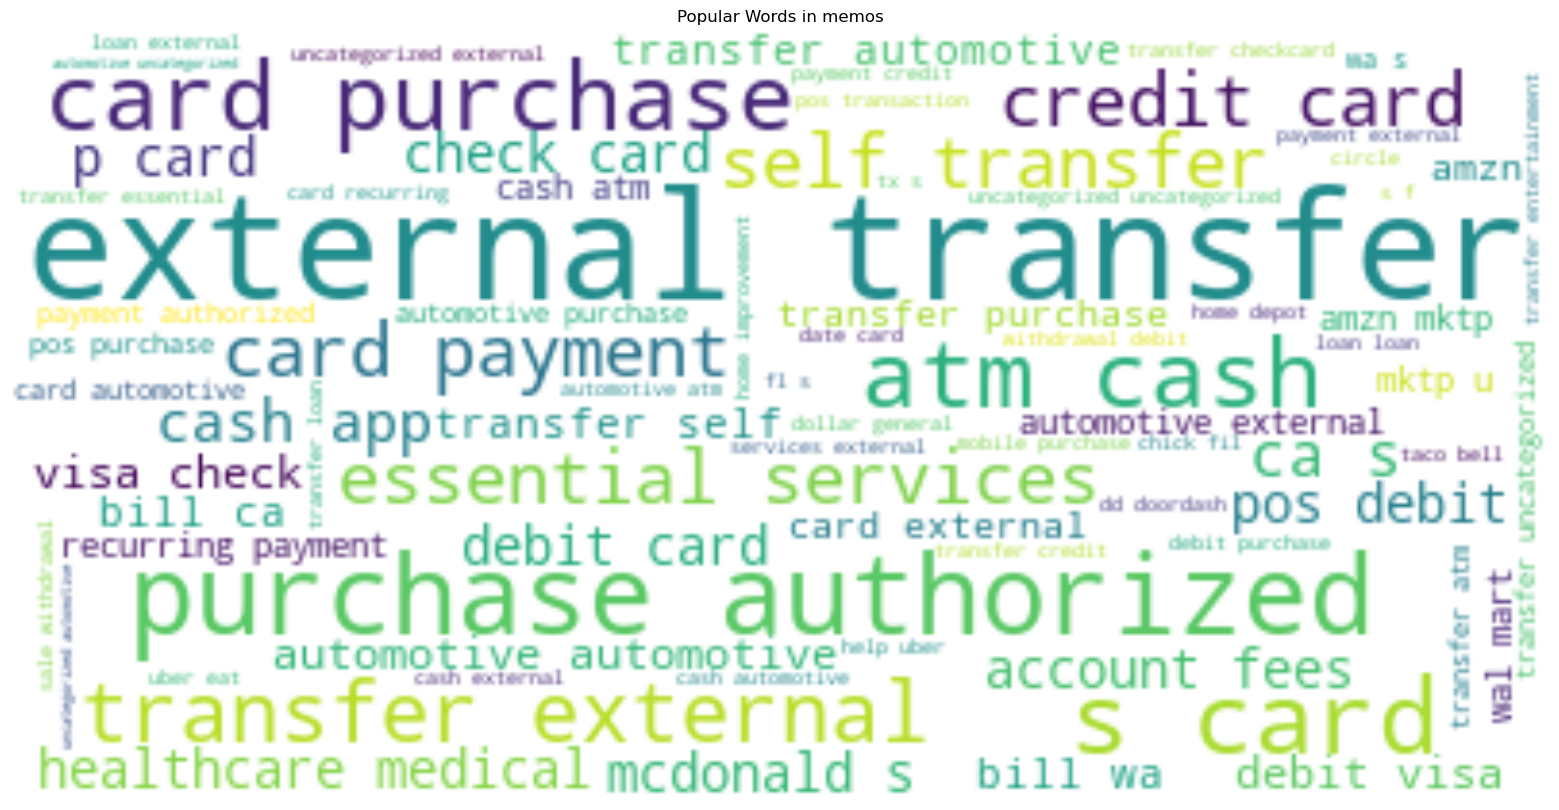

In [9]:
pop_wrds = " ".join( memo for memo in outflows.memo)
wordcloud = WordCloud(max_font_size=150, max_words=100, background_color="white").generate( pop_wrds )
plt.figure(figsize=(30, 10))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.title('Popular Words in memos')
plt.show()